This notebook contains a generator class for Keras called `BSONIterator` that can read directly from the BSON data. You can use it in combination with `ImageDataGenerator` for doing data augmentation.

In [1]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
keras.__version__, tf.__version__

('2.0.8', '1.1.0')

In [3]:
data_dir = "/home/manojps/Documents/deep_learning/Project"
#data_dir = "C:\\Users\\msaha\\Documents\\Deep_Learning\\Project\\"

train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

# train_bson_path = os.path.join(data_dir, "train_example.bson")
# num_train_products = 82

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768182

print(test_bson_path)

/home/manojps/Documents/deep_learning/Project/test.bson


# Part 1: Create lookup tables

The generator uses several lookup tables that describe the layout of the BSON file, which products and images are part of the training/validation sets, and so on.

You only need to generate these tables once, as they get saved to CSV files. If you already have these CSV files, skip to part 2.

## Lookup table for categories

In [4]:
categories_path = os.path.join(data_dir, "category_names.csv")
#categories_df = pd.read_csv(categories_path, index_col="category_id")
categories_df = pd.read_csv(categories_path)

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

#categories_df.to_csv("categories.csv")
categories_df.head()

,category_id,category_level1,category_level2,category_level3,category_idx
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [5]:
# Create a dataframe with category level1 idx
cat1_level_df = pd.DataFrame(categories_df.category_level1.unique())
cat1_level_df.rename(columns={0: "category_level1"}, inplace=True)
cat1_level_df["cat1_idx"] = pd.Series(range(len(cat1_level_df)), index=cat1_level_df.index)
cat1_level_df.head()

,category_level1,cat1_idx
0,ABONNEMENT / SERVICES,0
1,AMENAGEMENT URBAIN - VOIRIE,1
2,ANIMALERIE,2
3,APICULTURE,3
4,ART DE LA TABLE - ARTICLES CULINAIRES,4


In [6]:
cat1_level_df.cat1_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [7]:
# Merge categories_df and cat1_levle_df into categories_df
categories_df = pd.merge(categories_df, cat1_level_df, on="category_level1", how="inner")
categories_df.head()

,category_id,category_level1,category_level2,category_level3,category_idx,cat1_idx
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,0
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,1
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2,1
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3,1
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4,1


In [8]:
categories_df.cat1_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [9]:
# Create a dataframe with category level2 idx
cat2_level_df = pd.DataFrame(categories_df.category_level2.unique())
cat2_level_df.rename(columns={0:"category_level2"}, inplace=True)
cat2_level_df["cat2_idx"] = pd.Series(range(len(cat2_level_df)), index = cat2_level_df.index)
cat2_level_df.head()

,category_level2,cat2_idx
0,CARTE PREPAYEE,0
1,AMENAGEMENT URBAIN,1
2,SIGNALETIQUE,2
3,SIGNALISATION ROUTIERE,3
4,VOIRIE,4


In [10]:
cat2_level_df.cat2_idx.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [11]:
# Merge categories_df and cat2_level_df into categories_df
categories_df = pd.merge(categories_df, cat2_level_df, on="category_level2", how="inner")
categories_df.head()

,category_id,category_level1,category_level2,category_level3,category_idx,cat1_idx,cat2_idx
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,0,0
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,1,1
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2,1,1
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3,1,1
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4,1,2


In [12]:
categories_df.cat1_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 38,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 21, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 47,
       32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 48])

In [13]:
categories_df = categories_df.set_index("category_id")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx,cat1_idx,cat2_idx
category_id,,,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,0,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,1,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2,1,1
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3,1,1
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4,1,2


In [14]:
# Write dataframe to CSV file
categories_df.to_csv("categories.csv")

Create dictionaries for quick lookup of `category_id` to `category_idx` mapping.

In [15]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        #category_idx = ir[4] # Category level3
        category_idx = ir[5] # Category level1
        #category_idx = ir[6] # Category level2 
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [16]:
cat2idx, idx2cat = make_category_tables()

In [17]:
# Test if it works:
cat2idx[1000012755], idx2cat[4]

(1, 1000020743)

In [18]:
# Garbage collection
# https://stackoverflow.com/questions/32247643/how-to-delete-multiple-pandas-python-dataframes-from-memory-to-save-ram
list = [cat1_level_df, cat2_level_df]
del cat1_level_df, cat2_level_df
del list

## Read the BSON files

We store the offsets and lengths of all items, allowing us random access to the items later.

Inspired by code from: https://www.kaggle.com/vfdev5/random-item-access

Note: this takes a few minutes to execute, but we only have to do it once (we'll save the table to a CSV file afterwards).

In [19]:
def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break

            length = struct.unpack("<i", item_length_bytes)[0]

            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length

            item = bson.BSON.decode(item_data)
            product_id = item["_id"]
            num_imgs = len(item["imgs"])

            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row

            offset += length
            f.seek(offset)
            pbar.update()

    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [20]:
%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

100%|██████████| 7069896/7069896 [11:04<00:00, 10638.63it/s]


CPU times: user 4min 12s, sys: 52.4 s, total: 5min 4s
Wall time: 11min 17s


In [150]:
train_offsets_df.head()

,num_imgs,offset,length,category_id,index1,product_id
product_id,,,,,,
0,1,0,6979,1000010653,0,0
1,1,6979,7318,1000010653,1,1
2,1,14297,5455,1000004079,2,2
3,1,19752,4580,1000004141,3,3
4,1,24332,6346,1000015539,4,4


In [88]:
train_offsets_df.index

Int64Index([       0,        1,        2,        3,        4,        5,
                   6,        7,        8,        9,
            ...
            23620440, 23620441, 23620444, 23620446, 23620450, 23620452,
            23620453, 23620455, 23620457, 23620460],
           dtype='int64', name='product_id', length=7069896)

In [95]:
train_offsets_df.ix[23620450:23620457]

,num_imgs,offset,length,category_id
product_id,,,,
23620450,1,62481740634,3430,1000013009
23620452,1,62481744064,6524,1000002900
23620453,1,62481750588,8310,1000018290
23620455,1,62481758898,4476,1000006673
23620457,1,62481763374,8086,1000015912


In [22]:
train_offsets_df.to_csv("train_offsets.csv")

In [23]:
# How many products?
len(train_offsets_df)

7069896

In [24]:
# How many categories?
len(train_offsets_df["category_id"].unique())

5270

In [25]:
# How many images in total?
train_offsets_df["num_imgs"].sum()

12371293

## Create a random train/validation split

We split on products, not on individual images. Since some of the categories only have a few products, we do the split separately for each category.

This creates two new tables, one for the training images and one for the validation images. There is a row for every single image, so if a product has more than one image it occurs more than once in the table.

In [26]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.):
    # Find the product_ids for each category.
    category_dict = defaultdict(list)
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1. - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx, category_id]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "category_id", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)   
    return train_df, val_df

Create a 80/20 split. Also drop 90% of all products to make the dataset more manageable. (Note: if `drop_percentage` > 0, the progress bar doesn't go all the way.)

In [36]:
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.2, 
                                              drop_percentage=0.999)

7069896it [00:21, 330109.28it/s]
  0%|          | 5652/7069896 [00:02<47:14, 2492.43it/s]  


In [37]:
train_images_df.head()

,product_id,category_idx,category_id,img_idx
0,6964301,45,1000010653,0
1,7113938,45,1000010653,0
2,29527,45,1000010653,0
3,8371127,45,1000010653,0
4,13660127,45,1000010653,0


In [38]:
len(train_images_df.category_id.unique())

1036

In [39]:
categories_df['category_id'] = categories_df.index

In [40]:
categories_df.head()

,category_level1,category_level2,category_level3,category_idx,cat1_idx,cat2_idx,category_id
category_id,,,,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,0,0,1000021794
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,1,1,1000012764
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2,1,1,1000012776
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3,1,1,1000012768
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4,1,2,1000012755


In [41]:
train_images_df = pd.merge(train_images_df, categories_df, on ='category_id', how='inner')
train_images_df.head()

,product_id,category_idx_x,category_id,img_idx,category_level1,category_level2,category_level3,category_idx_y,cat1_idx,cat2_idx
0,6964301,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
1,7113938,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
2,29527,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
3,8371127,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
4,13660127,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455


In [42]:
val_images_df = pd.merge(val_images_df, categories_df, on='category_id', how='inner')
val_images_df.head()

,product_id,category_idx_x,category_id,img_idx,category_level1,category_level2,category_level3,category_idx_y,cat1_idx,cat2_idx
0,860,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
1,10305,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
2,10305,45,1000010653,1,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
3,10305,45,1000010653,2,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
4,10305,45,1000010653,3,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455


In [43]:
train_images_df.cat1_idx.unique()

array([45, 22,  6, 35, 47, 27, 10, 14,  5,  7, 29, 17, 43,  9, 11, 25, 21,
       32, 37,  4, 44, 41, 16, 28, 23, 24, 34, 42, 33, 19, 26,  2, 46, 48,
       18, 36, 15, 31])

In [44]:
#train_new['product_id'].count
len(train_images_df),len(val_images_df)

(8465, 1344)

In [45]:
train_images_df['category_level1'].value_counts()

TELEPHONIE - GPS                             916
DECO - LINGE - LUMINAIRE                     895
INFORMATIQUE                                 870
AUTO - MOTO                                  826
LIBRAIRIE                                    655
BIJOUX -  LUNETTES - MONTRES                 503
JEUX - JOUETS                                424
BRICOLAGE - OUTILLAGE - QUINCAILLERIE        330
BAGAGERIE                                    322
MUSIQUE                                      296
CHAUSSURES - ACCESSOIRES                     273
ELECTROMENAGER                               247
HYGIENE - BEAUTE - PARFUM                    247
MEUBLE                                       236
TV - VIDEO - SON                             205
SPORT                                        189
PHOTO - OPTIQUE                              187
ART DE LA TABLE - ARTICLES CULINAIRES        147
JARDIN - PISCINE                              80
LOISIRS CREATIFS - BEAUX ARTS - PAPETERIE     78
LITERIE             

In [46]:
val_images_df['category_level1'].value_counts()

TELEPHONIE - GPS                             202
INFORMATIQUE                                 161
DECO - LINGE - LUMINAIRE                     141
AUTO - MOTO                                  131
BIJOUX -  LUNETTES - MONTRES                 106
LIBRAIRIE                                    102
MUSIQUE                                       66
CHAUSSURES - ACCESSOIRES                      59
BAGAGERIE                                     58
JEUX - JOUETS                                 58
ELECTROMENAGER                                40
BRICOLAGE - OUTILLAGE - QUINCAILLERIE         39
HYGIENE - BEAUTE - PARFUM                     34
TV - VIDEO - SON                              32
PHOTO - OPTIQUE                               23
MEUBLE                                        22
ART DE LA TABLE - ARTICLES CULINAIRES         18
SPORT                                         13
DVD - BLU-RAY                                 10
LITERIE                                        7
TATOUAGE - PIERCING 

In [ ]:
# len(train_category1["category_idx"].unique()), len(val_images_df["category_idx"].unique())

Quickly verify that the split really is approximately 80-20:

In [ ]:
# cat_idx = 5196
# num_train = np.sum(train_category1['category_idx'] == cat_idx)
# num_val = np.sum(val_category1['category_idx'] == cat_idx)
# num_val/num_train

Close enough. ;-) Remember that we split on products but not all products have the same number of images, which is where the slightly discrepancy comes from. (Also, there tend to be fewer validation images if `drop_percentage` > 0.)

Save the lookup tables as CSV so that we don't need to repeat the above procedure again.

In [ ]:
#train_images_df.to_csv("train_images.csv")
#val_images_df.to_csv("val_images.csv")

In [47]:
train_images_df.to_csv("train_category_level1.csv")
val_images_df.to_csv("val_category_level1.csv")
#train_category2.to_csv("train_category2.csv")
#val_category2.to_csv("val_category2.csv")

# Part 2: The generator

First load the lookup tables from the CSV files (you don't need to do this if you just did all the steps from part 1).

In [48]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        #category_idx = ir[4] # Category level3
        category_idx = ir[5] # Category level1
        #category_idx = ir[6] # Category level2 
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [49]:
 #categories_df = pd.read_csv("categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

 #train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
#train_images_df = pd.read_csv("train_images.csv", index_col=0)
# train_images_df = pd.read_csv("train_category_level1.csv", index_col=0)
#val_images_df = pd.read_csv("val_images.csv", index_col=0)
 #val_images_df = pd.read_csv("val_category_level1.csv", index_col=0)

In [50]:
train_offsets_df.head()

,num_imgs,offset,length,category_id
product_id,,,,
0,1,0,6979,1000010653
1,1,6979,7318,1000010653
2,1,14297,5455,1000004079
3,1,19752,4580,1000004141
4,1,24332,6346,1000015539


In [146]:
val_images_df.head(10)

,product_id,category_idx_x,category_id,img_idx,category_level1,category_level2,category_level3,category_idx_y,cat1_idx,cat2_idx
0,860,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
1,10305,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
2,10305,45,1000010653,1,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
3,10305,45,1000010653,2,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
4,10305,45,1000010653,3,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
5,8926920,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
6,6462274,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
7,20568,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
8,7945385,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
9,6772047,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455


In [52]:
len(train_images_df)

8465

In [53]:
train_images_df['cat1_idx'].value_counts()

45    916
14    895
22    870
6     826
27    655
9     503
25    424
10    330
7     322
35    296
11    273
17    247
21    247
34    236
47    205
43    189
37    187
4     147
24     80
29     78
28     67
16     64
41     58
26     55
2      52
5      42
32     37
44     36
33     23
19     18
23     18
48     15
42     13
15     12
46     11
36     10
18      7
31      1
Name: cat1_idx, dtype: int64

The Keras generator is implemented by the `BSONIterator` class. It creates batches of images (and their one-hot encoded labels) directly from the BSON file. It can be used with multiple workers.

**Note:** For fastest results, put the train.bson and test.bson files on a fast drive (SSD).

See also the code in: https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py

In [54]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, lock, target_size=(180, 180), 
                 with_labels=True, batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)
        self.lock = lock

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Load the image.
            img = load_img(io.BytesIO(bson_img), target_size=self.target_size)

            # Preprocess the image.
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                #batch_y[i, image_row["category_idx"]] = 1
                batch_y[i, image_row["cat1_idx"]] = 1

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
#         return self._get_batches_of_transformed_samples(index_array)
        return self._get_batches_of_transformed_samples(index_array[0])
    

In [55]:
train_bson_file = open(train_bson_path, "rb")

Because the training and validation generators read from the same BSON file, they need to use the same lock to protect it.

In [56]:
import threading
lock = threading.Lock()

In [57]:
len(train_images_df['cat1_idx'].unique())

38

Create a generator for training and a generator for validation.

In [58]:
num_classes = 5270
#num_classes = len(train_images_df['category_idx'].unique())
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 128

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, lock,
                         batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, lock,
                       batch_size=batch_size, shuffle=True)

Found 8465 images belonging to 5270 classes.
Found 1344 images belonging to 5270 classes.


How fast is the generator? Create a single batch:

In [59]:
next(train_gen)  # warm-up

%time bx, by = next(train_gen)

CPU times: user 268 ms, sys: 68 ms, total: 336 ms
Wall time: 1.2 s


Does it really output images and one-hot encoded class labels? Note that the images are pre-processed (and augmented) and therefore may look weird.

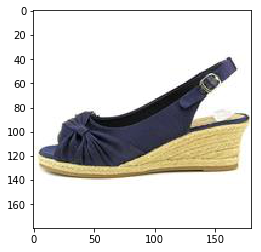

In [60]:
plt.imshow(bx[-1].astype(np.uint8))

In [61]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1    CHAUSSURES - ACCESSOIRES
category_level2          CHAUSSURES DETENTE
category_level3                  ESPADRILLE
category_idx                           1562
cat1_idx                                 11
cat2_idx                                 92
category_id                      1000010554
Name: 1000010554, dtype: object

In [62]:
%time bx, by = next(val_gen)

CPU times: user 264 ms, sys: 88 ms, total: 352 ms
Wall time: 1.21 s


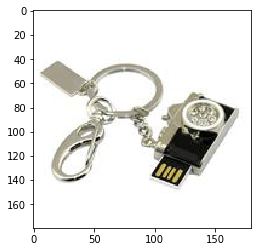

In [63]:
plt.imshow(bx[-1].astype(np.uint8))

In [64]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1                       INFORMATIQUE
category_level2                           TABLETTE
category_level3    TABLETTE TACTILE RECONDITIONNEE
category_idx                                  2615
cat1_idx                                        22
cat2_idx                                       201
category_id                             1000022307
Name: 1000022307, dtype: object

# Part 3: Training

Create a very simple Keras model and train it, to test that the generators work.

In [65]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
__________

In [67]:
batch_size = 128
# To train the model:
model.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,
                    epochs = 1,
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,
                     workers = 8,
                   verbose =1)

Epoch 1/1
66/66 [==============================] - 652s - loss: 3.7349 - acc: 0.1206 - val_loss: 2.7114 - val_acc: 0.1702

In [68]:
model.save('model0.h5')

In [69]:
# To evaluate on the validation set:
y = model.evaluate_generator(val_gen, steps=num_val_images // batch_size, workers=8)

In [74]:
y

[2.6540143224928112, 0.171875]

In [ ]:
num_val_images, batch_size

In [70]:
y_pred = model.predict_generator(val_gen, steps=num_val_images//batch_size)

In [71]:
np.set_printoptions(threshold=np.nan)

In [72]:
np.max(y_pred, axis=1)

array([ 0.23855443,  0.24192107,  0.13803399,  0.13593166,  0.28812724,
        0.14914721,  0.26099813,  0.1979484 ,  0.15999374,  0.11100385,
        0.1637235 ,  0.19755256,  0.1414104 ,  0.14052543,  0.66644758,
        0.1323518 ,  0.16411701,  0.24406151,  0.15728939,  0.17902146,
        0.13678104,  0.14374608,  0.18738264,  0.21362114,  0.19181491,
        0.15717094,  0.22280394,  0.36431792,  0.16146813,  0.17998023,
        0.1472941 ,  0.20943645,  0.20050897,  0.16161475,  0.13033432,
        0.13958763,  0.17249781,  0.15854551,  0.13531646,  0.19837923,
        0.18247768,  0.17135723,  0.14548761,  0.16335718,  0.21822375,
        0.21479625,  0.17033802,  0.23472936,  0.15042706,  0.1532466 ,
        0.10673691,  0.20086288,  0.32589892,  0.16277982,  0.15466623,
        0.15687121,  0.11111456,  0.20581318,  0.19073071,  0.13103238,
        0.09973056,  0.13828105,  0.17123345,  0.12552984,  0.16849111,
        0.15619847,  0.11852587,  0.17338334,  0.1396348 ,  0.15

In [ ]:
np.max(y_pred)

In [ ]:
y_pred[300][5236], np.argmax(y_pred[300])

In [73]:
np.argmax(y_pred, axis=1)

array([45, 45,  6, 27, 45, 45, 45, 45, 45, 14,  6, 27,  6,  6, 27, 45, 27,
       45,  6, 45, 14, 14, 45,  6,  6, 45, 45, 45, 45,  6, 45, 45,  6, 14,
       14, 45, 35,  6,  6, 45,  6,  6, 45, 45, 45,  6,  6, 45,  6, 45,  6,
       45, 45, 45,  6,  6,  6, 45,  6, 45, 45, 45, 45, 45,  6,  6, 45, 45,
        6, 27, 45, 45,  6, 45, 45,  6, 45, 45, 35,  6, 45,  6,  6, 45, 45,
       45, 45,  6, 45,  6, 35,  6,  6, 14,  6,  6,  6,  6,  6, 45,  6,  6,
       45, 45, 45, 45, 45,  6,  6,  6, 45,  6, 45, 14, 45,  6,  6, 45, 45,
        6,  6, 45, 45, 45, 45,  6, 45,  6,  6, 45, 45, 45, 45, 45,  6, 45,
        6, 45, 45, 14,  6,  6, 45, 45,  6,  6,  6,  6, 45, 45, 45, 45,  6,
       45, 45, 45, 45,  6, 45, 45, 45, 27,  6,  6, 45, 45,  6,  6, 45, 45,
       45, 45, 14, 45, 45,  6, 27,  6,  6, 45,  6,  6, 45, 27, 45, 14, 14,
       45, 45, 14, 45,  6,  6, 27,  6,  6, 45, 45,  6,  6,  6, 45, 45, 45,
       45, 45,  6,  6, 45, 27,  6, 45,  6, 45, 45, 45, 45, 45, 45,  6, 45,
        6, 45, 45,  6,  6

In [75]:
len(y_pred), len(val_images_df), len(y)

(1280, 1344, 2)

In [145]:
y_pred.shape, val_images_df.shape

((1280, 5270), (1344, 10))

In [136]:
val_temp2 = val_images_df[0:len(y_pred)]
len(val_temp2)
val_temp2.head(2)

,product_id,category_idx_x,category_id,img_idx,category_level1,category_level2,category_level3,category_idx_y,cat1_idx,cat2_idx
0,860,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
1,10305,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455


In [149]:
val_temp2['cat1_pred'] = np.argmax(y_pred, axis=1)
val_temp2.head(2)

/home/manojps/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,product_id,category_idx_x,category_id,img_idx,category_level1,category_level2,category_level3,category_idx_y,cat1_idx,cat2_idx,cat1_pred
0,860,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455,45
1,10305,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455,45


In [155]:
val_temp2.shape

(1280, 11)

In [138]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in val_temp2.itertuples():
        category_id = ir[3]
        #category_idx = ir[4] # Category level3
        category_idx = ir[11] # Category level1
        #category_idx = ir[6] # Category level2 
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [139]:
cat2idx, idx2cat = make_category_tables()

In [157]:
len(cat2idx)

228

In [140]:
train_offsets_df['product_id'] = train_offsets_df.index
train_offsets_df.head()

,num_imgs,offset,length,category_id,index1,product_id
product_id,,,,,,
0,1,0,6979,1000010653,0,0
1,1,6979,7318,1000010653,1,1
2,1,14297,5455,1000004079,2,2
3,1,19752,4580,1000004141,3,3
4,1,24332,6346,1000015539,4,4


In [154]:
prod_id_array = pd.Series(val_temp2['product_id'].unique())
prod_id_array.shape

(747,)

In [148]:
train_offsets_df2 = train_offsets_df.loc[prod_id_array]
train_offsets_df2.head()

,num_imgs,offset,length,category_id,index1,product_id
product_id,,,,,,
860,1,5067806,5408,1000010653,860,860
10305,4,63811236,22316,1000010653,10305,10305
8926920,1,24517401149,7789,1000010653,8926920,8926920
6462274,1,17055255311,7871,1000010653,6462274,6462274
20568,1,129616582,4563,1000010653,20568,20568


In [153]:
train_offsets_df2.shape

(747, 6)

In [152]:
train_images_df2, val_images_df2 = make_val_set(train_offsets_df2, split_percentage=0.2, 
                                              drop_percentage=0)

747it [00:00, 237161.84it/s]
100%|██████████| 747/747 [00:00<00:00, 19897.03it/s]


# Part 4: Test set predictions

Note: The previous version of this kernel used `BSONIterator` to load the test set images in batches. However, storing the prediction results takes up a huge amount of memory. 

I suggest using a different kind of generator instead, something like the following:

```
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

submission_df = pd.read_csv(data_dir + "sample_submission.csv")
submission_df.head()

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
data = bson.decode_file_iter(open(test_bson_path, "rb"))

with tqdm(total=num_test_products) as pbar:
    for c, d in enumerate(data):
        product_id = d["_id"]
        num_imgs = len(d["imgs"])

        batch_x = np.zeros((num_imgs, 180, 180, 3), dtype=K.floatx())

        for i in range(num_imgs):
            bson_img = d["imgs"][i]["picture"]

            # Load and preprocess the image.
            img = load_img(io.BytesIO(bson_img), target_size=(180, 180))
            x = img_to_array(img)
            x = test_datagen.random_transform(x)
            x = test_datagen.standardize(x)

            # Add the image to the batch.
            batch_x[i] = x

        prediction = model.predict(batch_x, batch_size=num_imgs)
        avg_pred = prediction.mean(axis=0)
        cat_idx = np.argmax(avg_pred)
        
        submission_df.iloc[c]["category_id"] = idx2cat[cat_idx]        
        pbar.update()
        
submission_df.to_csv("my_submission.csv.gz", compression="gzip", index=False)        
```

In [ ]:
num_classes = 5270
#num_classes = len(train_images_df['category_idx'].unique())
num_test_images = len(test_images_df)
batch_size = 1000

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
test_datagen = ImageDataGenerator()
test_gen = BSONIterator(test_bson_file, test_images_df, train_offsets_df, 
                         num_classes, train_datagen, lock,
                         batch_size=batch_size, shuffle=True)